In [151]:
from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
import sys
import django
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from scipy.sparse import find

import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from MulticoreTSNE import MulticoreTSNE as mTSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
import pickle
import scipy.sparse
import datetime
import scipy.stats as st
import scoping.utils.learning_utils as lu
from scoping.models import *
from utils.text import *
import matplotlib
import re



In [178]:
df = pd.read_csv('../data/all_categories.csv')

In [179]:
# Driver was coded only as an impact, its driver was uncoded
df.loc[df['id']==112762,"6 - 07 Aridity/dryness"] = 1
df.loc[df['id']==112762,"6 - 72 Conflict"] = 0
df.loc[df['id']==112762,"4 - 72 Conflict"] = 1
df.loc[df['id']==112762,"6 - 76 Human water use"] = 1

# Unspecific climate change driver not coded
df.loc[df['id']==746862,"6 - 13 Other (physical systems)"] = 1
df.loc[df['id']==746862,"4 - 72 Conflict"] = 1
df.loc[df['id']==746862,"4 - 73 Displacement and migration"] = 1

# Driver and impact wrong way round
df.loc[df['id']==2342058,"4 - 72 Conflict"] = 1
df.loc[df['id']==2342058,"6 - 07 Aridity/dryness"] = 1



In [180]:

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
new_index = df[(df['seen']==1) & (df['ar5']==0)].index
rel_index = df[df['relevant']==1].index
physical_index = df[df['ca_rated']==1].index

df.head()

,Unnamed: 0,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,...,8 - 8.05. Quantitative - statistical,8 - 8.06. Qualitative - literature review,8 - 8.07. Qualitative - expert interviews,8 - 8.08. Qualitative - household surveys,8 - 8.09. Mixed methods,8 - 8.10. Case studies,8 - 8.11. Remote sensing,9 - observations,ca_rated,12 - Physical systems
0,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,1,3316697,Survival of enchytraeids from three areas was ...,Survival of frost and drought conditions in th...,enchytraeidae; alpine; arctic; drought; gut co...,['Ecology; Soil Science'],0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,2,1344198,The effect of the El Nino - Southern Oscillati...,Winter rainfall in Iran: ENSO and aloft wind i...,Iran; ENSO; aloft wind; winter rainfall,['Multidisciplinary Sciences'],0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,3,289649,"Permafrost, mainly of discontinuous type, that...","Thermokarst lake, hydrological flow and water ...",Permafrost; Thermokarst lakes; Hydrological cy...,"['Engineering, Civil; Geosciences, Multidiscip...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,4,399966,"Since 2005, Morocco has designated 28 Importan...",Factors Influencing Species-Richness of Breedi...,Breeding waterfowl; Diversity; Spatial scale; ...,['Ecology; Environmental Sciences'],0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [181]:
Category.objects.get(name=c.split(" - ")[1],level=6).equivalents.filter(level=5)

<QuerySet [<Category: 5.3. Human and managed systems>]>

,driver,n,intermediate_driver,primary_driver
0,6 - 01 CO2 concentration,24.0,0.0,24.0
1,6 - 02 Air or land surface temperature changes,422.0,9.0,413.0
2,6 - 03 Extreme temperature,117.0,0.0,117.0
3,6 - 04 Radiation,10.0,0.0,10.0
4,6 - 05 Changes in precipitation,259.0,10.0,249.0


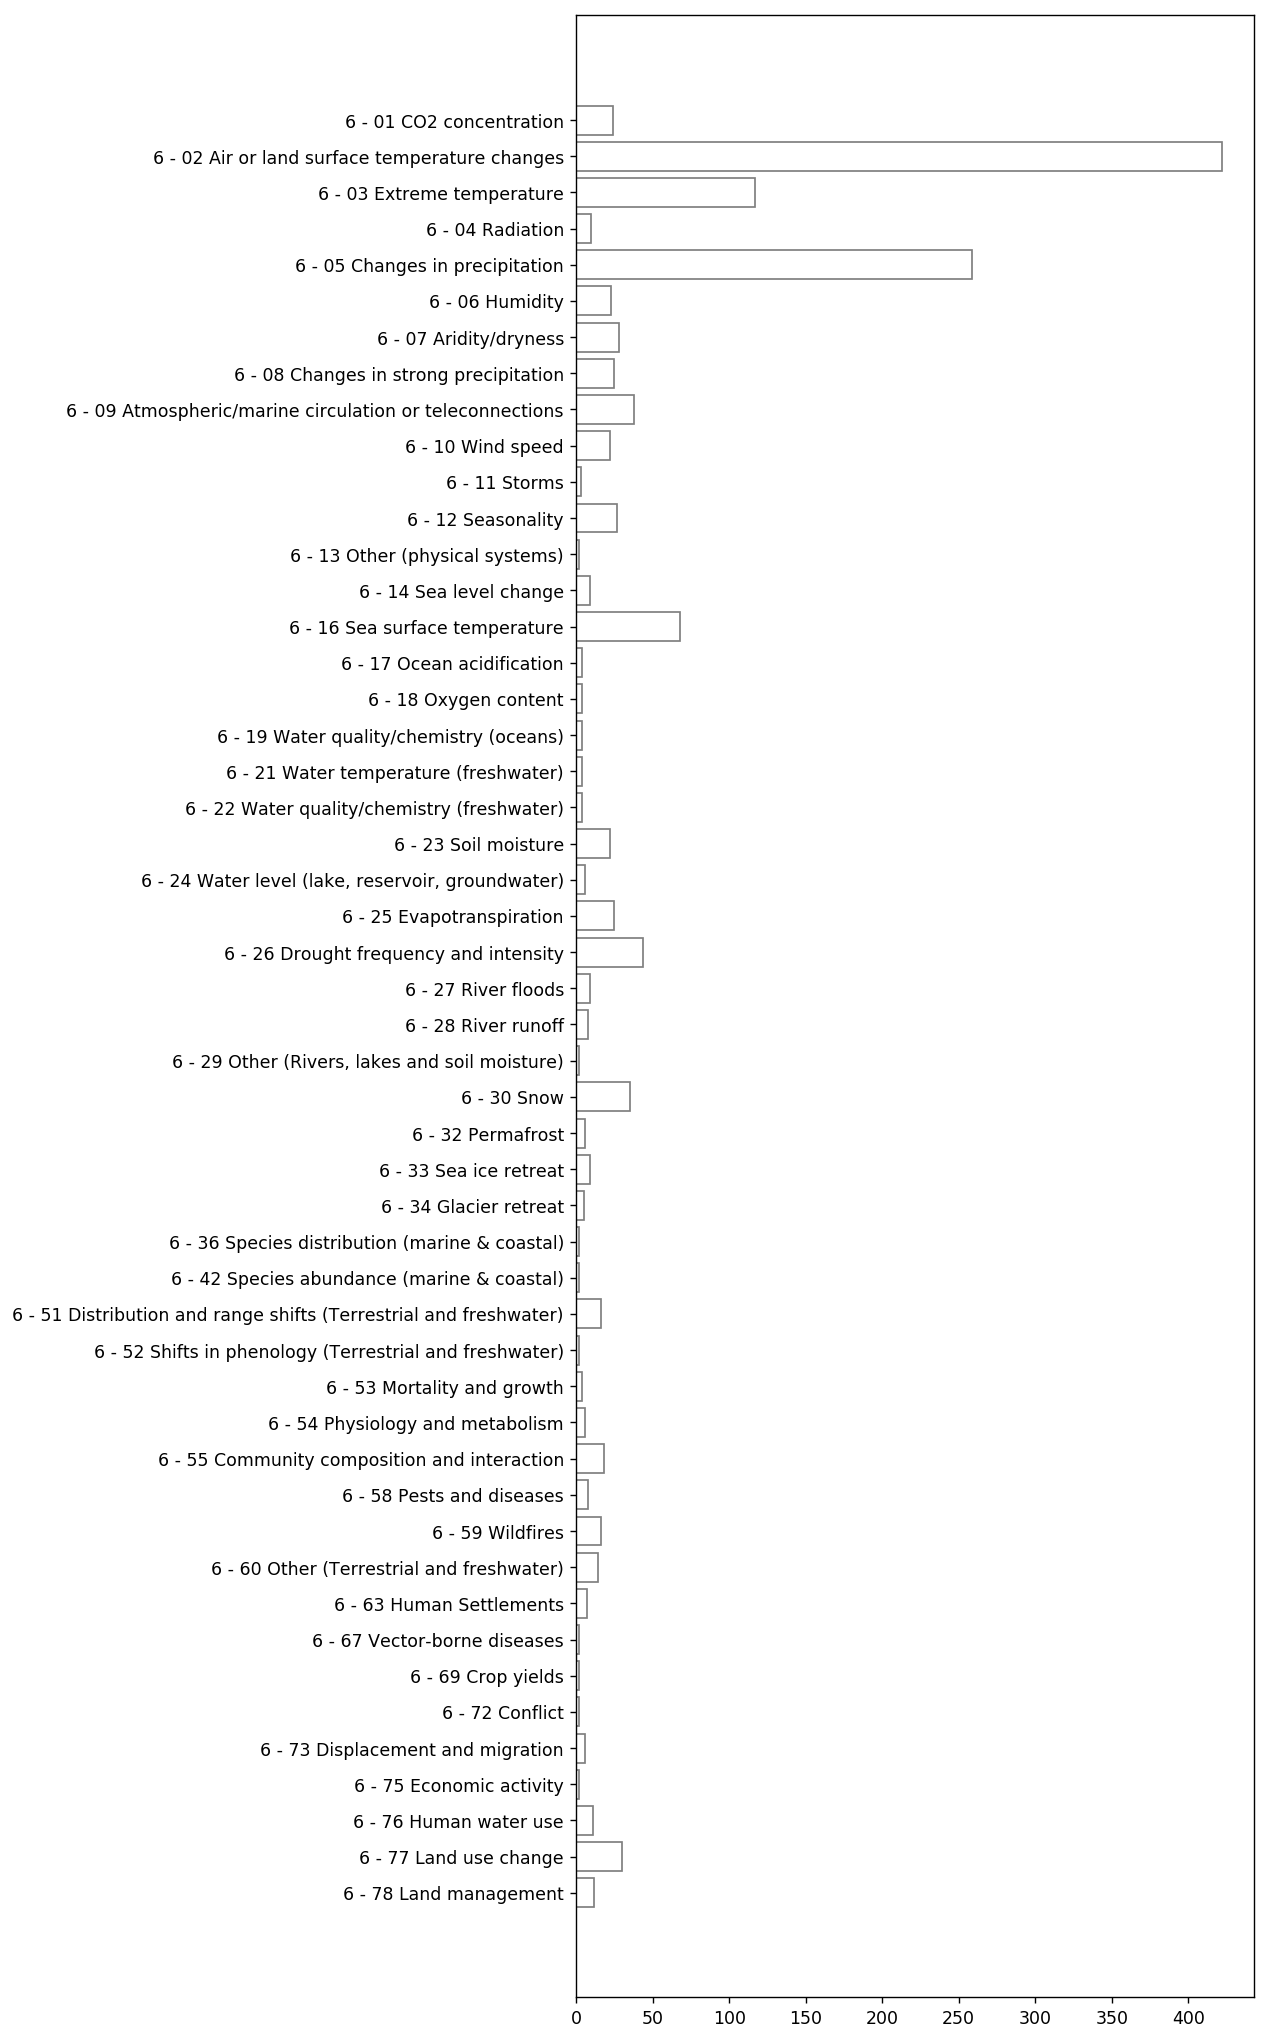

In [182]:
drivers = []
driver_dict = []
fig, ax = plt.subplots(dpi=125, figsize=(7,21))
i = 0
for c in df.columns:
    if "prediction" in c:
        continue
    if re.match("^6 - " ,c):
        im = c.replace("6 - ","4 - ")
        n = df[c].sum()
        if im not in df.columns:
            di = 0
            p_d = n
        else:
            di = df.loc[df[im]==1,c].sum()
            p_d = df.loc[df[im]==0,c].sum()
        if n < 2:
            continue
        driver_dict.append({"driver": c, "n":n, "intermediate_driver": di, "primary_driver":p_d})
        ax.barh(i,n,color="None",edgecolor="grey")
        i+=1
        
plt.gca().invert_yaxis()

driver_df = pd.DataFrame.from_dict(driver_dict)

ax.set_yticks(driver_df.index)
ax.set_yticklabels(driver_df['driver'])

driver_df.head()

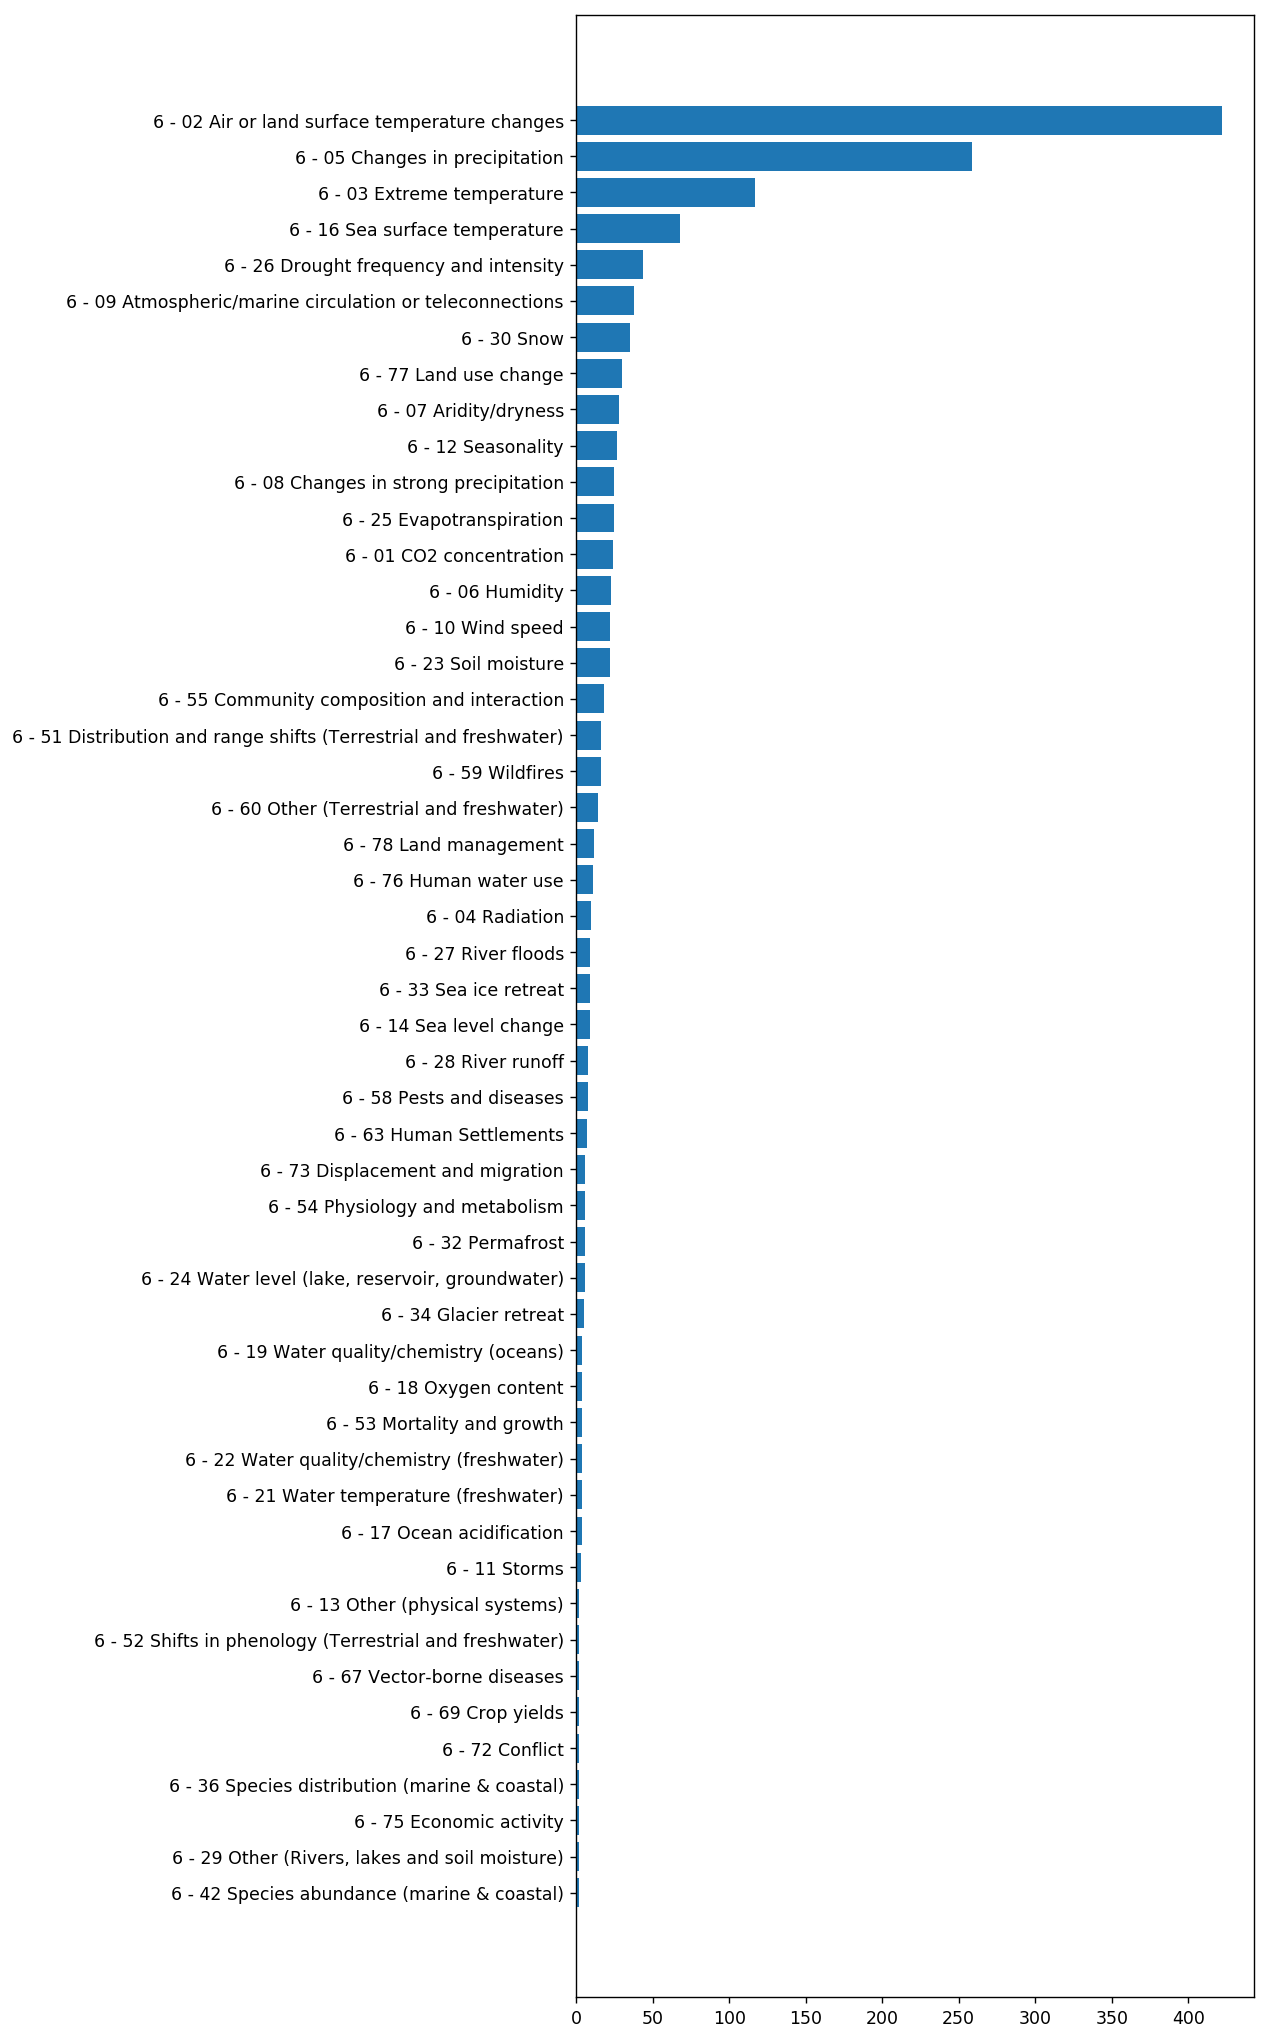

In [185]:
fig, ax = plt.subplots(dpi=125, figsize=(7,21))

pdf = driver_df.sort_values('n').reset_index(drop=True)
ax.barh(pdf.index, pdf['n'])


ax.set_yticks(pdf.index)
ax.set_yticklabels(pdf['driver'])

plt.show()

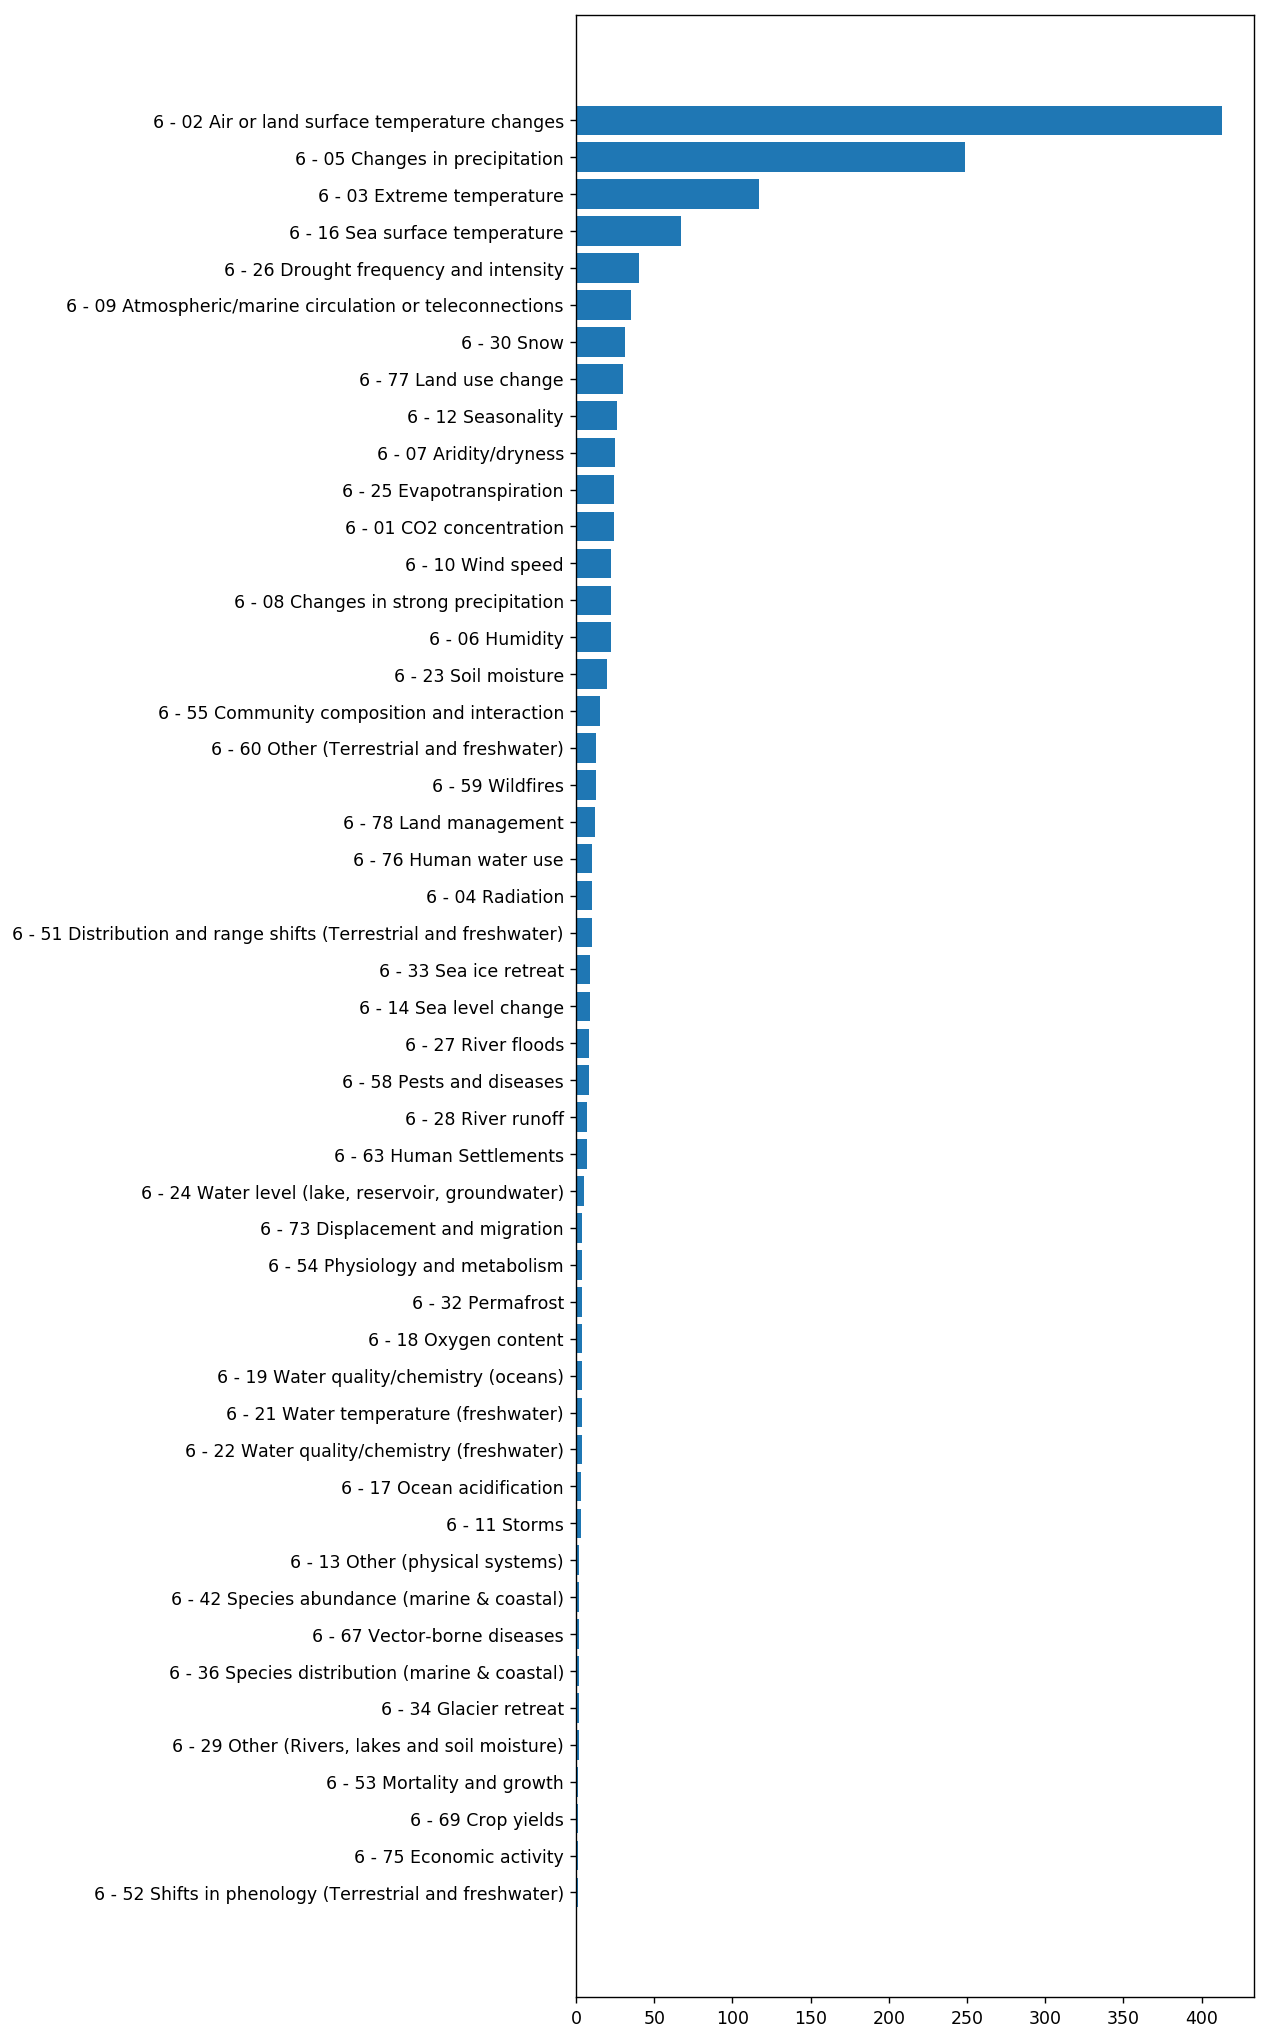

In [186]:
fig, ax = plt.subplots(dpi=125, figsize=(7,21))

pdf = driver_df.query('primary_driver>0').sort_values('primary_driver').reset_index(drop=True)
ax.barh(pdf.index, pdf['primary_driver'])


ax.set_yticks(pdf.index)
ax.set_yticklabels(pdf['driver'])

plt.show()

In [196]:
cs = 
for c in Category.objects.filter(project=178,level=4):
    for dc in Category.objects.filter(project=178,level=6):
        

In [169]:
df.loc[df['id']==112762,"6 - 07 Aridity/dryness"]

41459    0.0
Name: 6 - 07 Aridity/dryness, dtype: float64

In [194]:
for i, row in df.loc[(df['6 - 36 Species distribution (marine & coastal)']==1)].iterrows():
    print("\n",row['title'])
    print(row['content'])
    d = Doc.objects.get(pk=row['id'])
    print(d.id)
    print("impacts:")
    print(d.docusercat_set.filter(category__level=4).values('category__name','user__username'))
    print("drivers:")
    print(d.docusercat_set.filter(category__level=6).values('category__name','user__username'))


 Anger and Sadness: Gendered Emotional Responses to Climate Threats in Four Island Nations
Climate change presents an important threat to community livelihoods and well-being around the world. Biophysical vulnerability to the effects of climate change, such as sea level rise, coastal erosion, changing flora and fauna, and changing precipitation patterns are predicted to affect island nations in particular. Emotional geographies offers a theoretical entry point to understand how changing landscapes, which are often imbued with emotion and personal significance, may result in heightened emotional states and result in different outcomes depending on the severity of these changes and the biophysical vulnerability that produces them. Historically, emotion and gender have been closely linked; we use biophysical vulnerability to climate change, along with emotion and gender, to argue for a differentiated perspective on how men and women in different places may experience different emotional 

In [137]:
wf = df[
    (df['6 - 59 Wildfires']==1)
]
print(wf.shape)
wf

(16, 308)


,Unnamed: 0,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,...,6 - 63 Human Settlements - k_prediction,6 - 63 Human Settlements - k_prediction_binary,6 - 73 Displacement and migration - k_prediction,6 - 73 Displacement and migration - k_prediction_binary,6 - 76 Human water use - k_prediction,6 - 76 Human water use - k_prediction_binary,6 - 77 Land use change - k_prediction,6 - 77 Land use change - k_prediction_binary,6 - 78 Land management - k_prediction,6 - 78 Land management - k_prediction_binary
7124,7124,136763,Disturbance affects most terrestrial ecosystem...,"Fire, hurricane and carbon dioxide: effects on...",disturbance; elevated CO2; fire; global enviro...,['Plant Sciences'],0.0,1.0,1.0,0.0,...,0.008267,0.0,0.010046,0.0,0.004845,0.0,0.020119,0.0,0.021510,0.0
7679,7679,61424,Fire history was reconstructed for an area of ...,Fire regimes at the transition between mixedwo...,boreal forest; Canada; climate change; dendroe...,['Ecology'],0.0,1.0,1.0,0.0,...,0.008290,0.0,0.008881,0.0,0.005195,0.0,0.041506,0.0,0.146675,0.0
9590,9590,575069,Wildfires are increasing in frequency and seve...,Too hot to trot? Evaluating the effects of wil...,Ochotona; pika; talus; thermal refuge; wildlife,['Forestry'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13676,13676,677708,Much of our understanding of the response of s...,Managing the matrix: decadal responses of euca...,Australia; biodiversity; Eucalyptus spp.; fire...,['Ecology; Environmental Sciences'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25281,25281,298778,Climate warming has the potential to directly ...,Subalpine plants show short-term positive grow...,0,['Plant Sciences'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26752,26752,310905,Understanding how changes in the boreal fire r...,Interannual variability of surface energy exch...,0,"['Environmental Sciences; Geosciences, Multidi...",0.0,1.0,1.0,0.0,...,0.007444,0.0,0.014566,0.0,0.011827,0.0,0.009434,0.0,0.009339,0.0
35337,35337,441243,Climate change and forest disturbances are thr...,Declining water yield from forested mountain w...,climate change; evapotranspiration; forest hyd...,['Biodiversity Conservation; Ecology; Environm...,0.0,1.0,1.0,0.0,...,0.005655,0.0,0.008522,0.0,0.009700,0.0,0.044773,0.0,0.028031,0.0
39754,39754,1481880,Recent and projected increases in the frequenc...,Mixed severity fire effects within the Rim fir...,Rim fire; Spatial autocorrelation; Mixed-sever...,['Forestry'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49204,49204,10906,Greenhouse gas emissions have significantly al...,A global overview of drought and heat-induced ...,Climate change; Drought effects; Forest die-of...,['Forestry'],0.0,1.0,1.0,0.0,...,0.009023,0.0,0.007047,0.0,0.014307,0.0,0.014318,0.0,0.005925,0.0
51095,51095,777910,Following changes in vegetation structure and ...,Evidence of fuels management and fire weather ...,fire progression; fire severity; fuels reducti...,['Ecology; Environmental Sciences'],0.0,1.0,1.0,0.0,...,0.009580,0.0,0.010228,0.0,0.023135,0.0,0.020892,0.0,0.064545,0.0


In [142]:
wf[list(driver_df.query('n>1')['driver'])]

,6 - 01 CO2 concentration,6 - 02 Air or land surface temperature changes,6 - 03 Extreme temperature,6 - 04 Radiation,6 - 05 Changes in precipitation,6 - 06 Humidity,6 - 07 Aridity/dryness,6 - 08 Changes in strong precipitation,6 - 09 Atmospheric/marine circulation or teleconnections,6 - 10 Wind speed,...,6 - 60 Other (Terrestrial and freshwater),6 - 63 Human Settlements,6 - 67 Vector-borne diseases,6 - 69 Crop yields,6 - 72 Conflict,6 - 73 Displacement and migration,6 - 75 Economic activity,6 - 76 Human water use,6 - 77 Land use change,6 - 78 Land management
7124,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25281,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35337,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39754,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
49204,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51095,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
wf[list(driver_df.query('n>1')['driver'])].sum(axis=1)

7124     3.0
7679     1.0
9590     1.0
13676    1.0
25281    2.0
26752    1.0
35337    7.0
39754    7.0
49204    5.0
51095    7.0
53459    1.0
53544    3.0
63805    4.0
65949    6.0
74580    1.0
79913    4.0
dtype: float64

In [ ]:
qid = 8272
revectorize = True
retransform = False
if revectorize:
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=4, max_df=0.8, strip_accents='unicode', 
        max_features=20000,
        tokenizer=snowball_stemmer(),
        #sublinear_tf=True
    )
    vec.fit(df.loc[seen_index,'content'].astype("str"))

    X = vec.transform(df['content'].astype("str"))#+" " + df['title'].astype("str"))   
    with open (f'../data/vec_{qid}_prel.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz(f'../data/X_{qid}_prel.npz', X)
else:
    with open (f'../data/vec_{qid}_prel.pickle','rb') as f:
        vec = pickle.load(f)
        if retransform:
            X = vec.transform(df['content'].astype("str"))
            scipy.sparse.save_npz(f'../data/X_{qid}_prel.npz', X)
        else:
            X = scipy.sparse.load_npz(f'../data/X_{qid}_prel.npz')
            
            
print(df.shape)
print(X.shape)

In [73]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

import scoping.utils

from importlib import reload  
reload(scoping.utils.learning_utils)


classes = list(driver_df.query('n>10')['driver'])
y = np.matrix(df[classes])
print(y.shape)

multimodels = [
    #{
    #    'title': 'One vs rest SVC', 
    #    'model': OneVsRestClassifier(SVC(kernel='linear', probability=True))
    #},
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
    #{
    #    'title': 'Random forest', 
    #    'model': OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight="balanced"))
    #},
    
    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_drivers, metrics, df = lu.cross_validate_models(X, y, multimodels, physical_index, n_splits=6, classes=classes, df = df)

(84832, 21)
1


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/max/softwar

2


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/max/softwar

3


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv

4


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv

5


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/max/softwar

6


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv

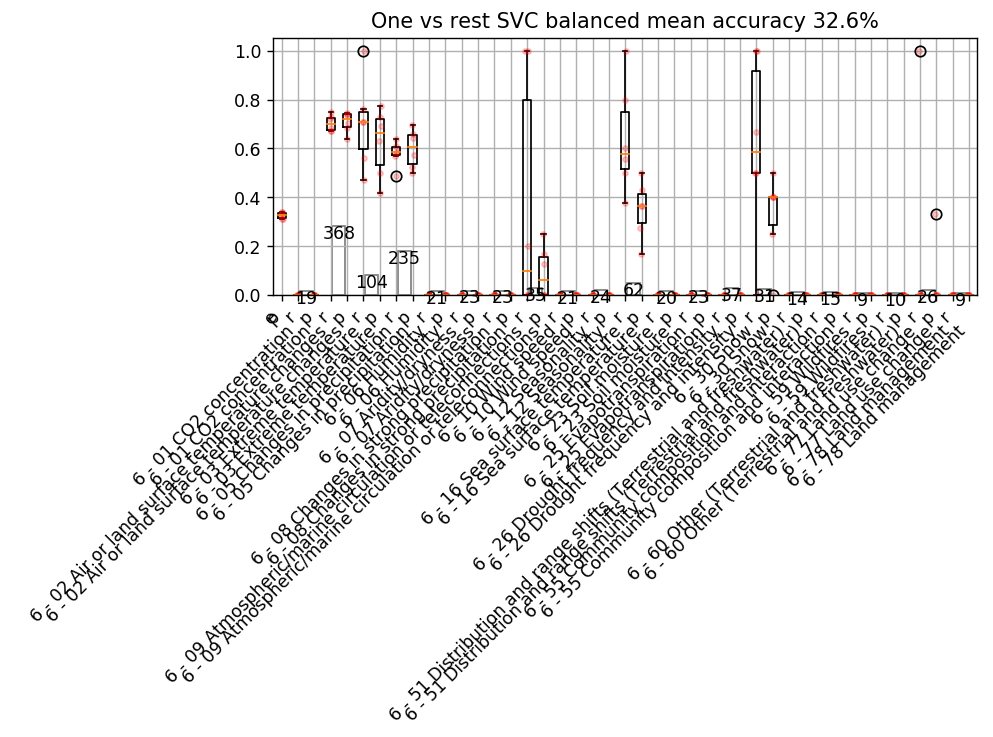

In [74]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output(multimodels_drivers, metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[rel_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[rel_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

In [131]:
y_pred = np.zeros((y[physical_index].shape[0],y[physical_index].shape[1]+1))
y_pred[:,:-1] = np.array(list(df.loc[list(physical_index),cols].values))
np.where(y_pred.sum(axis=1)==0,1,0).sum()

231

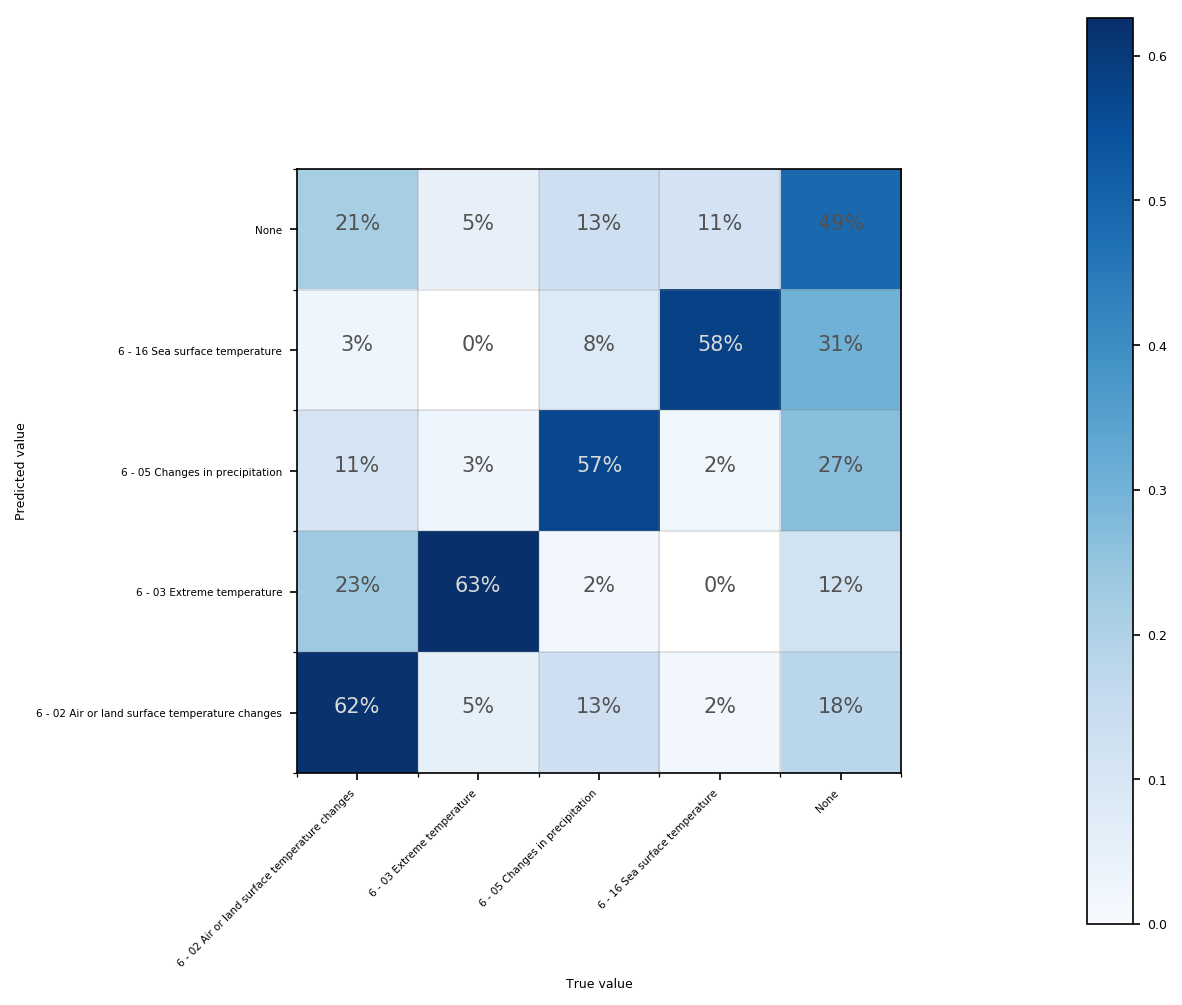

In [134]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8,8),dpi=150)

classes = list(driver_df.query('n>50')['driver'])


cols = [f"{c} - k_prediction_binary" for c in classes]

y_pred = np.zeros((y[physical_index].shape[0],y[physical_index].shape[1]+1))
y_pred[:,:-1] = np.array(list(df.loc[list(physical_index),cols].values))
y_pred[:,len(classes)] = np.where(y_pred.sum(axis=1)==0,1,0)
   
y_true = np.zeros((y[physical_index].shape[0],y[physical_index].shape[1]+1))
y_true[:,:-1] = y[physical_index]
y_true[:,len(classes)] = np.where(y_true.sum(axis=1)==0,1,0)


confusion_matrix = np.zeros(shape=(len(cols)+1,len(cols)+1),dtype=float)

classes = classes+["None"]

for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n = 0
        for i in range(len(physical_index)):
            if j==k:
                if y_pred[i,j]+y_true[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1
        confusion_matrix[j,k]=n
        
    #sums_pred = y_pred.sum(axis=1).ravel()
    #confusion_matrix[k+1,j]=y_true[np.argwhere(sums_pred==0).ravel(),j].sum()
    #sums_true = y_true.sum(axis=1).ravel()
    #confusion_matrix[j,k+1]=y_pred[np.argwhere(sums_true==0).ravel(),j].sum()
    #confusion_matrix[j+1,k+1] = y_pred[np.argwhere(sums_true+sums_pred==0)].shape[0]


def plot_confusion_matrix(cm, all_classes, norm=None, broad_cats = [], ls=False):
    cm = np.copy(cm)
    if norm is not None:
        cm = cm/cm.sum(axis=norm,keepdims=True)
    cm[cm == 0] = np.nan

    mat = ax.imshow(cm, cmap="Blues",vmin=0,origin="lower")
    ax.set_xticks(np.arange(-.5, cm.shape[0], 1), minor=True);
    ax.set_yticks(np.arange(-.5, cm.shape[0], 1), minor=True);

    ax.grid(which="minor",color='grey', linestyle='-', linewidth=0.2)

    if ls:
        for j, c in enumerate(all_classes):
            for k, c in enumerate(all_classes):
                n  = cm[k,j]
                if pd.isna(n):
                    n = 0
                if n > 0.5:
                    color="#d9d9d9"
                else:
                    color="#525252"
                ax.text(j,k, f"{n:.0%}",ha="center",color=color)
                
            #if j < len(all_classes)+21:    
            #    ax.text(j,len(all_classes)-0.25,f"{y_true[:,j].sum():,.0f}",ha="center",va="center",color="#525252")
            #    ax.text(len(all_classes)-0.25, j, f"{y_pred[:,j].sum():,.0f}",ha="center",va="center", color="#525252")

    ax.set_xticks(list(range(len(all_classes))))
    ax.set_xticklabels([x.replace("4 - ","") for x in all_classes],rotation=45,ha="right",fontsize=5)

    ax.set_yticks(list(range(len(all_classes))))
    ax.set_yticklabels([x.replace("4 - ","") for x in all_classes],ha="right",fontsize=5)
    ax.set_xlabel("True value", fontsize=6)
    ax.set_ylabel("Predicted value", fontsize=6)


    cbar = fig.colorbar(mat, ax=ax, pad=0.2)
    cbar.ax.tick_params(labelsize=6)
    if norm ==0:
        cbar.set_label("% of True values")
    
    for bc in broad_cats:
        rect = patches.Rectangle((bc['start']-0.5,bc['start']-0.5),bc['size'],bc['size'],fill=False)
        ax.add_patch(rect)
    

plot_confusion_matrix(confusion_matrix, classes, norm=1, ls=True)   
#plot_confusion_matrix(confusion_matrix,classes, norm=1)

In [77]:
classes = list(driver_df.query('n>50')['driver'])

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

import scoping.utils

from importlib import reload  
reload(scoping.utils.learning_utils)
y = np.matrix(df[classes])
print(y.shape)

multimodels = [
    #{
    #    'title': 'One vs rest SVC', 
    #    'model': OneVsRestClassifier(SVC(kernel='linear', probability=True))
    #},
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
    #{
    #    'title': 'Random forest', 
    #    'model': OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight="balanced"))
    #},
    
    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_drivers_few, metrics, df = lu.cross_validate_models(X, y, multimodels, physical_index, n_splits=6, classes=classes, df = df)

(84832, 4)
1
2
3
4
5
6


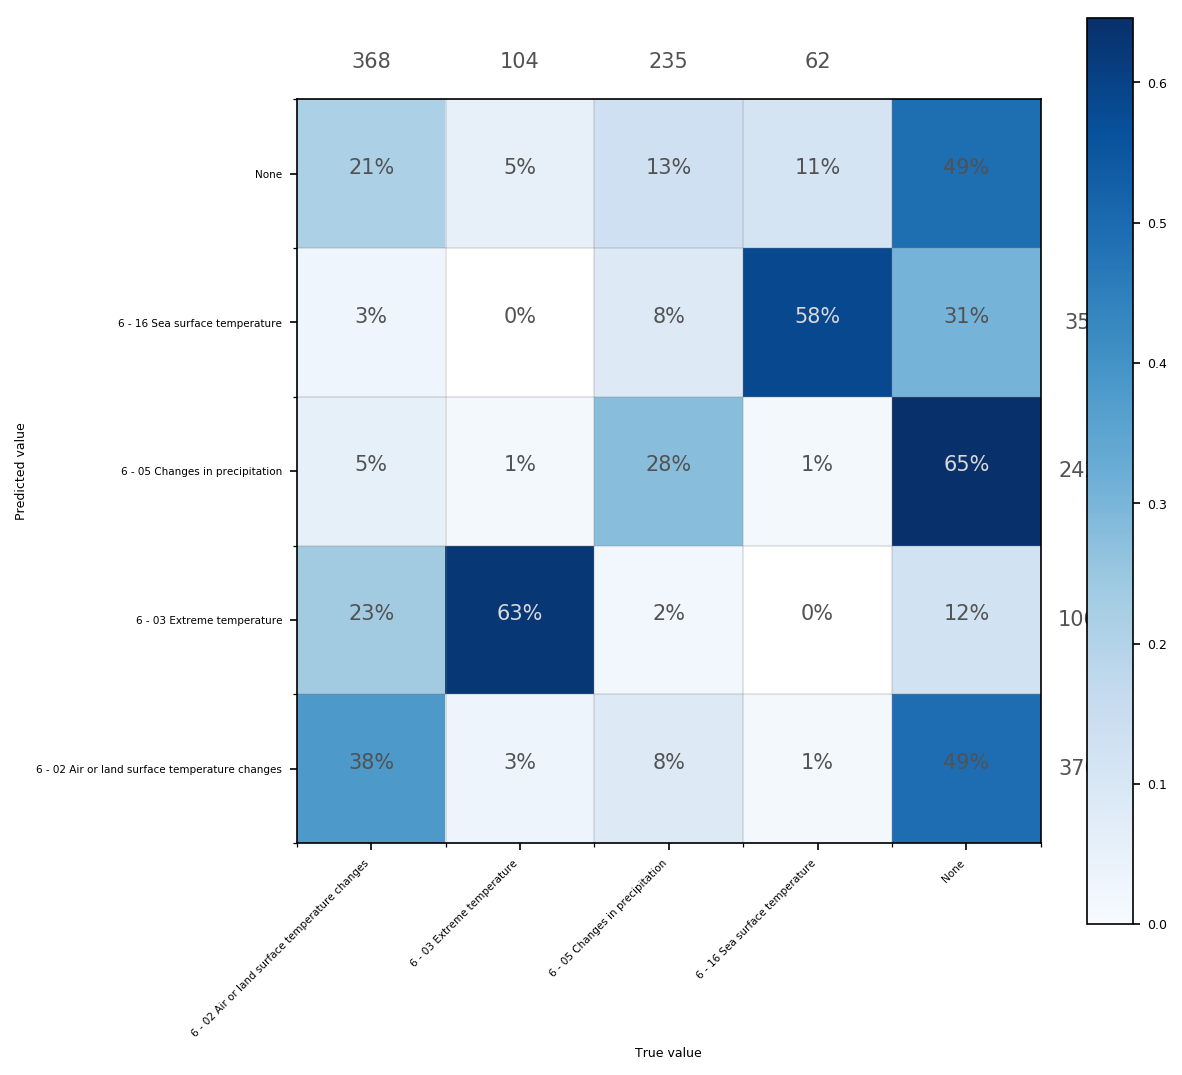

In [102]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8,8),dpi=150)

classes = list(driver_df.query('n>50')['driver'])

cols = [f"{c} - k_prediction_binary" for c in classes]
y_pred = np.array(list(df.loc[list(physical_index),cols].values))
   
y_true = y[physical_index]

confusion_matrix = np.zeros(shape=(len(cols)+1,len(cols)+1),dtype=float)

for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n = 0
        for i in range(len(physical_index)):
            if j==k:
                if y_pred[i,j]+y_true[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1
        confusion_matrix[j,k]=n
        
    sums_pred = y_pred.sum(axis=1).ravel()
    confusion_matrix[k+1,j]=y_true[np.argwhere(sums_pred==0).ravel(),j].sum()
    sums_true = y_true.sum(axis=1).ravel()
    confusion_matrix[j,k+1]=y_pred[np.argwhere(sums_true==0).ravel(),j].sum()
    confusion_matrix[j+1,k+1] = y_pred[np.argwhere(sums_true+sums_pred==0)].shape[0]

        
plot_confusion_matrix(confusion_matrix,classes + ["None"], norm=1, ls=True)

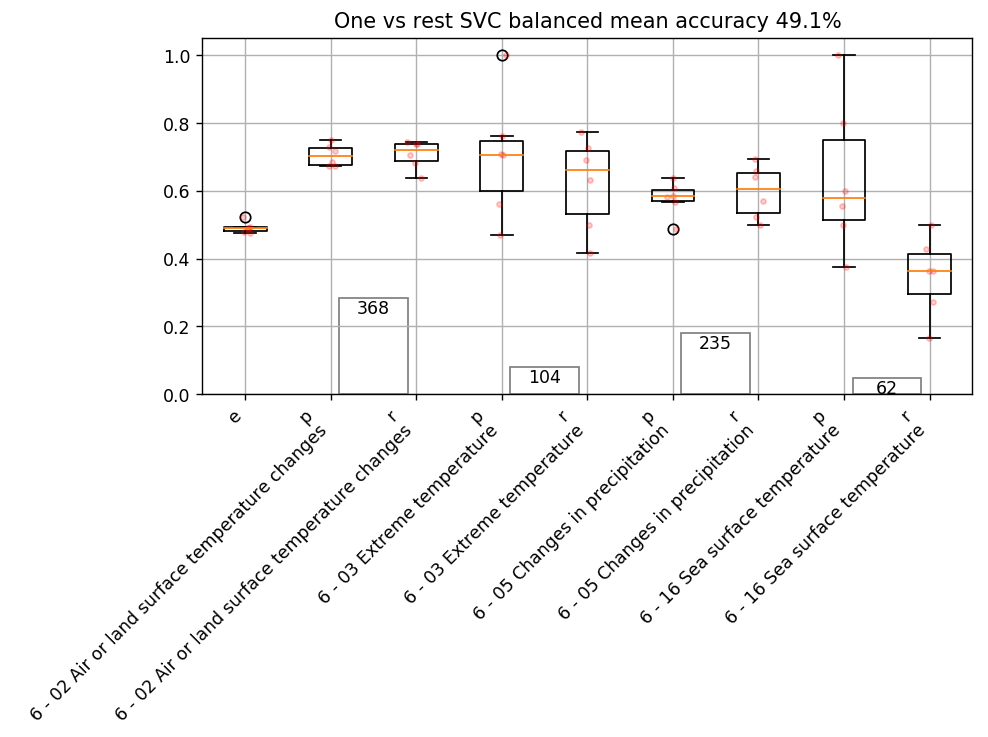

In [66]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output(multimodels_drivers_few, metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[rel_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[rel_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

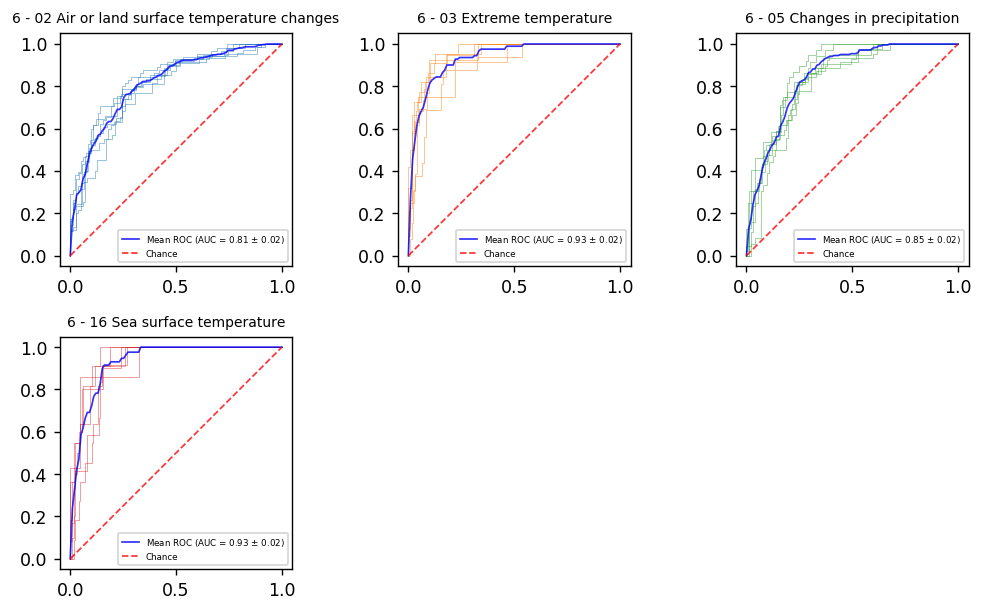

In [67]:
from scipy import interp
fig = plt.figure(dpi=125, figsize=(8,5))
for model in multimodels_drivers_few:
    for j,c in enumerate(classes):
        ax = fig.add_subplot(2,3,j+1)
        mean_fpr = np.linspace(0, 1, 100)
        mean_auc = np.mean(model[f'auc\n{c}'])
        std_auc = np.std(model[f'auc\n{c}'])
        tprs = []
        for i in range(len(model['i'])):
            viz = ax.plot(
                model[f'fpr\n{c}'][i],
                model[f'tpr\n{c}'][i],
                lw=0.5,
                alpha=0.5,
                color=f"C{j}"
            )
            
            interp_tpr = interp(mean_fpr, model[f'fpr\n{c}'][i], model[f'tpr\n{c}'][i])
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=1, alpha=.8)
        ax.set_title(c,fontsize=8)
        ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
            label='Chance', alpha=.8)

        ax.legend(fontsize=5)
        ax.set_aspect("equal")
            
fig.tight_layout()

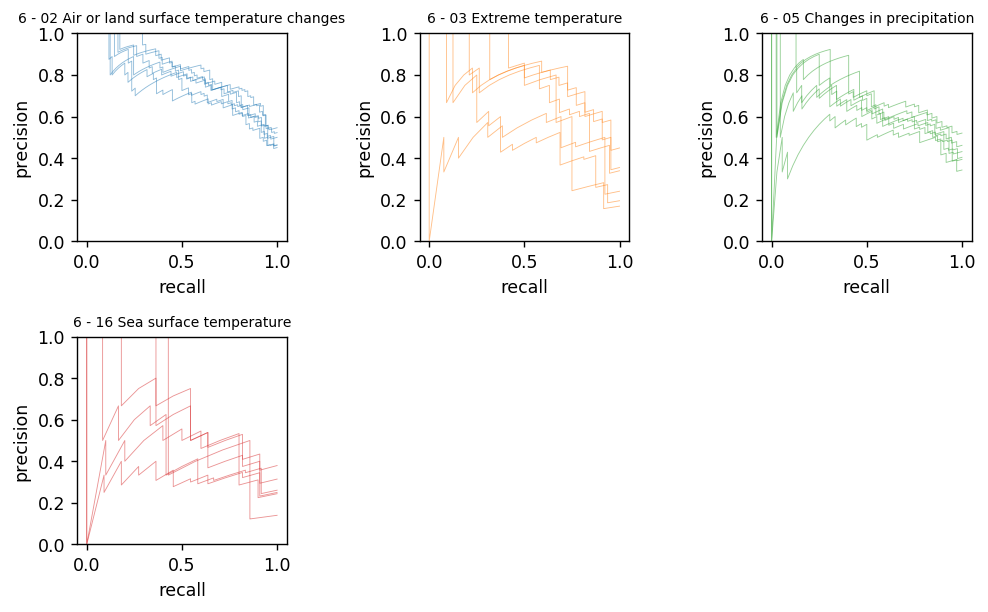

In [69]:
from scipy import interp
fig = plt.figure(dpi=125, figsize=(8,5))
for model in multimodels_drivers_few:
    for j,c in enumerate(classes):
        ax = fig.add_subplot(2,3,j+1)
        mean_fpr = np.linspace(0, 1, 100)
        mean_auc = np.mean(model[f'auc\n{c}'])
        std_auc = np.std(model[f'auc\n{c}'])
        tprs = []
        for i in range(len(model['i'])):
            viz = ax.plot(
                model[f'rec\n{c}'][i],
                model[f'prec\n{c}'][i],
                lw=0.5,
                alpha=0.5,
                color=f"C{j}"
            )
        ax.set_ylabel('precision')
        ax.set_xlabel('recall')
        ax.set_title(c,fontsize=8)
        ax.set_ylim((0,1))
        
fig.tight_layout()